In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math

from sklearn import linear_model
from random import shuffle
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

In [2]:
df_music = pd.read_csv('../music_data/dataset-11-26.csv')

In [3]:
df_music.head()

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount
0,1,100.000000,Percy Faith,"Theme From ""A Summer Place""",1960,5001152,1180
1,2,63.287830,Jim Reeves,He'll Have To Go,1960,4377343,4240
2,3,48.428383,The Everly Brothers,Cathy's Clown,1960,4180758,4114
3,30,10.594976,The Everly Brothers,Let It Be Me,1960,697716,4114
4,70,6.056689,The Everly Brothers,So Sad,1960,804269,4114


# 0 Utility

In [4]:
def z_score_norm(df, feature_list):
    """ Do the z-score method on selected features in feature_list. 
        z = (x - mean)/std

    Args:
        df (pandas.DataFrame): data set
        feature_list   (list): a list of features, each element is a string
    """
    
    for col in feature_list:
        df[col] = (df[col] - df[col].mean())/(df[col].std())
        
        
        
def do_log(df, feature_list):
    '''Do logarithm on selected features in feature_list.
    
    Args:
        df (pandas.DataFrame): data set
        feature_list   (list): a list of features, each element is a string
    '''
    
    for col in feature_list:
        df[col] = np.log(df[col])
        
        
        
def powerlaw_rank(df_music):
    ''' Do powerlaw on the original rank.
        y = 100*rank^(-0.66)
        However, I find that differnent coefficient and exponent do not affect MAE. Don't know why.
    
    Args:
        df_music (pandas.DataFrame): dataset
    '''
    
    df_music.insert(1, 'RankPowerlaw', df_music.Rank)  # insert right next to column 'Rank'
    df_music['RankPowerlaw'] = df_music['RankPowerlaw'].astype('float')
    for i in range(0, len(df_music)):
        df_music.iat[i,1] = 100 * math.pow(df_music.iat[i,1], -0.66)

In [5]:
def performance_statistics(model_name, target, pred):
    '''Plot a table of performance statistics
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    mae   = mean_absolute_error(target, pred)
    medae = median_absolute_error(target, pred)
    r2    = r2_score(target, pred)
    
    columns = ['Model', 'Mean Absolute Error', 'Median Absolute Error', 'R2 Score']
    cell_text = [['%s' % model_name, '%1.3f' % mae, '%1.3f' % medae, '%1.3f' % r2]]
    
    nrow = 1
    ncol = len(columns)
    
    fig = plt.figure(figsize=(ncol*2, nrow*0.2))
    ax = fig.add_subplot(111)
    ax.axis('off')
    
    table = ax.table(cellText=cell_text, colLabels=columns, loc='center')
    table.set_fontsize(14)
    table.scale(1.5, 1.5)
    
    
    
def error_distribution(model_name, target, pred):
    '''Plot a histogram of the error distribution
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    err = pred - target   # error is a Series
    min_err = err.min()
    max_err = err.max()
    fig = plt.figure()
    ax = err.plot.hist(bins=20, figsize=(7,7), edgecolor='black')
    ax.set_xticks(np.arange(math.floor(min_err), math.ceil(max_err)))
    ax.set_title('%s - Error Distribution' % model_name, fontsize=18)
    ax.set_xlabel('Error', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.grid()
    
    fig.savefig('../figure/%s_error_dist.png' % model_name)
    
    

def prediction_error_map(model_name, target, pred):
    '''Plot the prediction error map (similar to confusion matrices in classification problems)
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    y_min = target.min()*0.98
    y_max = target.max()*1.01
    fig, ax = plt.subplots(figsize=(7,7))
    #plt.scatter(target, pred, edgecolor='black', s=15)
    plt.scatter(target, pred, s=13)
    ax.plot([y_min, y_max], [y_min, y_max], 'k--', lw=2)
    ax.set_xticks(np.arange(math.floor(y_min),math.ceil(y_max)))
    ax.set_yticks(np.arange(math.floor(y_min),math.ceil(y_max)))
    ax.set_title('%s - Prediction Error Map' % model_name, fontsize=18)
    #ax.set_xlabel('Real Spotify (log) Play Count', fontsize=14)
    ax.set_xlabel('Target', fontsize=14)
    ax.set_ylabel('Prediction', fontsize=14)
    #ax.axis([y_min,y_max,y_min,y_max])
    ax.grid()
    
    fig.savefig('../figure/%s_error_map.png' % model_name)
    
    
    
def permutation_test(model,target,pred):
    '''do permuation tests
    
    Args:
        model_name: model
        target (Series):  target data
        pred   (ndarray): predition results
    ''' 
    pred = cross_val_predict(model, X=feature, y=target, cv=10)
    mae  = mean_absolute_error(target,pred)
    mae_list=[mae]
    count=0
    while count<100:
        count = count+1 
        target_to_list = target.tolist()
        shuffle(target_to_list)
        target_per = pd.DataFrame({'playcount':target_to_list})
        pred1 = cross_val_predict(model, X=feature, y=target_per, cv=10)
        mae_shuffle = mean_absolute_error(target,pred1)
        mae_list.append(mae_shuffle)
    num_bins = 20
    fig, ax = plt.subplots(figsize=(7,7))
    n, bins, patches = ax.hist(mae_list, num_bins)
    ax.set_title('Permutation test')
    ax.set_xlabel('$Log(playcount)-mae$', fontsize=12)
    ax.set_ylabel('Counts', fontsize=12)
    ax.get_children()[0].set_color('r')
    ax.grid()
    
    
    
def evaluation(model, feature, target):
    """ Run the model on X and y using cross validation. Then output:
        1) performance statistics
        2) error distributions
        3) prediction error map
        
    Args:
        model   (object):    the machine learning object to fit the data
        feature (DataFrame): feature data
        target  (Series):    target  data
        
    This is version 0.11.10 (Nov. 10th)
    
    Todo:
        parameter "model" should be a list of models in the future
    """
    
    model_name = str(model)        # 'LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)'
    end = model_name.find('(')
    model_name = model_name[0:end] # 'LinearRegression'
    
    '''Do the prediction by cross validation'''
    pred = cross_val_predict(model, X=feature, y=target, cv=10)  # default is 10-fold
    
    print('This is the plots/reports of %s'  % model_name)
        
    error_distribution(model_name, target, pred)
    
    prediction_error_map(model_name, target, pred)
    
    #permutation_test(model, target, pred)
    
    performance_statistics(model_name, target, pred)    

# 1 Baseline

In [6]:
df_music.head()

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount
0,1,100.000000,Percy Faith,"Theme From ""A Summer Place""",1960,5001152,1180
1,2,63.287830,Jim Reeves,He'll Have To Go,1960,4377343,4240
2,3,48.428383,The Everly Brothers,Cathy's Clown,1960,4180758,4114
3,30,10.594976,The Everly Brothers,Let It Be Me,1960,697716,4114
4,70,6.056689,The Everly Brothers,So Sad,1960,804269,4114


In [7]:
do_log(df_music, feature_list=['RankPowerlaw', 'SpotifyPlayCount', 'WikiWordCount'])

In [8]:
z_score_norm(df_music, feature_list=['Rank', 'RankPowerlaw', 'Year', 'WikiWordCount'])

In [35]:
feature = df_music.loc[:,['Rank', 'Year', 'WikiWordCount']]
target  = df_music.loc[:,['SpotifyPlayCount']]

In [10]:
lr = linear_model.LinearRegression()

In [11]:
reg = linear_model.Ridge (alpha = .8)

This is the plots/reports of LinearRegression


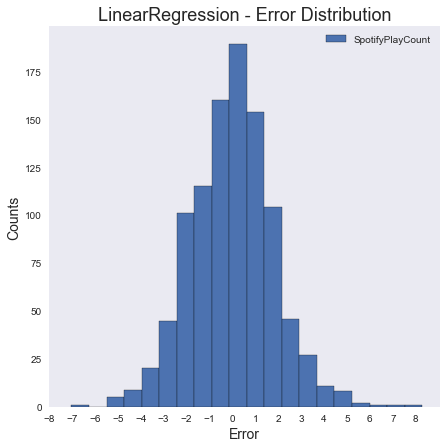

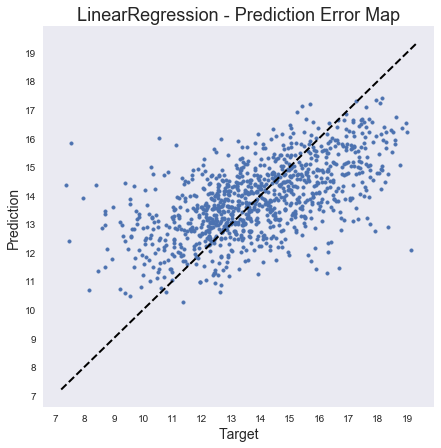

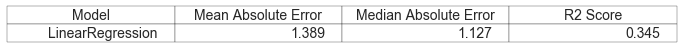

In [36]:
evaluation(lr, feature, target)

In [13]:
pred = cross_val_predict(lr, X=feature, y=target, cv=10)  # default is 10-fold

# Twenty Best

In [14]:
def top20BetterThanPrediction(pred, target):
    array = target - pred

In [15]:
best = target - pred

In [16]:
best.insert(0, 'Prediction', pred)

In [17]:
best.insert(0, 'Target', target)

In [20]:
best.describe()

,Target,Prediction,SpotifyPlayCount
count,1000.000000,1000.000000,1000.000000
mean,13.842613,13.844204,-0.001591
std,2.213413,1.309355,1.792003
min,7.348588,10.269408,-9.146701
25%,12.403722,12.942698,-1.163941
50%,13.669471,13.761994,-0.043397
75%,15.417700,14.693945,1.165258
max,19.119101,18.482368,6.757474


In [23]:
best_index = best.nlargest(20, columns='SpotifyPlayCount').index

In [28]:
best.nlargest(20, columns='SpotifyPlayCount')

,Target,Prediction,SpotifyPlayCount
838,19.119101,12.361627,6.757474
91,18.355697,12.986217,5.369481
265,17.907229,12.685789,5.221440
126,16.255563,11.158628,5.096936
186,16.674597,11.852165,4.822432
282,17.717049,13.302573,4.414476
854,17.322973,13.004618,4.318355
884,17.636537,13.375865,4.260672
236,15.707082,11.470469,4.236613
185,15.887576,11.816661,4.070915


In [26]:
df_music.iloc[best_index, :]

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount
838,1.260355,-0.895673,Marvin Gaye and Tammi Terrell,Ain't No Mountain High Enough,0.869184,19.119101,-1.172889
91,1.018332,-0.804922,Sam Cooke,Wonderful World,-1.565505,18.355697,0.368790
265,0.430560,-0.546468,Ben E. King,Stand By Me,-1.217692,17.907229,-0.294944
126,0.015662,-0.317855,Billy Bland,Let The Little Girl Dance,-1.565505,16.255563,-1.926475
186,1.640678,-1.024482,Maurice Williams and the Zodiacs,Stay,-1.565505,16.674597,-0.877912
282,1.536954,-0.990845,Dave Brubeck,Take Five,-1.217692,17.717049,0.585449
854,-0.088062,-0.252266,Scott Mckenzie,San Francisco (Be Sure to Wear Flowers in Your...,0.869184,17.322973,-0.932924
884,1.052906,-0.818362,Cream,White Room,1.216996,17.636537,-0.369247
236,-0.364660,-0.055015,Marcels,Blue Moon,-1.217692,15.707082,-1.801011
185,1.606103,-1.013385,Barrett Strong,Money,-1.565505,15.887576,-0.917606


In [29]:
lr2 = linear_model.LinearRegression()

In [30]:
lr2.fit(feature, target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [32]:
feature.head()

,RankPowerlaw,Year,WikiWordCount
0,3.935938,-1.565505,-0.492742
1,3.186031,-1.565505,0.735088
2,2.747363,-1.565505,0.706129
3,0.256225,-1.565505,0.706129
4,-0.660456,-1.565505,0.706129


In [31]:
lr2.coef_

array([[ 0.57494743,  0.41838252,  1.01484447]])

# Twenty Worst

In [37]:
best.nsmallest(20, columns='SpotifyPlayCount')

,Target,Prediction,SpotifyPlayCount
158,7.540090,16.686792,-9.146701
969,7.348588,14.076632,-6.728045
749,8.377471,14.706933,-6.329462
116,7.931644,13.667661,-5.736017
590,10.539509,15.858599,-5.319090
876,9.691964,14.613990,-4.922026
523,9.375601,14.199463,-4.823863
532,8.693161,13.470114,-4.776953
529,8.679822,13.426564,-4.746742
233,7.454720,12.160831,-4.706111


In [38]:
worst_index = best.nsmallest(20, columns='SpotifyPlayCount').index

In [39]:
df_music.iloc[worst_index, :]

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount
158,-1.678503,3.186031,Ray Charles,I Can't Stop Loving You,-0.869879,7.540090,1.117501
969,-0.779558,0.330867,Andy Kim,"Baby, I Love You",1.564809,7.348588,-0.647797
749,1.709828,-1.046339,Paul Revere and The Raiders,Let Me,1.564809,8.377471,0.718877
116,-0.330086,-0.081730,Anita Bryant,Paper Roses,-1.565505,7.931644,0.309639
590,0.223111,-0.438189,The Temptations,"Run Away Child, Running Wild",1.564809,10.539509,1.511430
876,1.433229,-0.956129,Bill Cosby,Little Ole Man (Uptight-Everything's Alright),0.869184,9.691964,1.030360
523,-1.090731,0.750386,The Ray Charles Singers,Love Me with All Your Heart (Cuando Calienta E...,-0.174254,9.375601,-0.038514
532,1.018332,-0.804922,The Dave Clark Five,I Like It Like That,0.173558,8.693161,-0.029936
529,0.568859,-0.613067,The Dave Clark Five,Can't You See That She's Mine,-0.174254,8.679822,-0.029936
233,-0.502960,0.058973,Linda Scott,Don't Bet Money Honey,-1.217692,7.454720,-1.179521
